In [4]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's print the list of all the datasets that come built-in with the Seaborn library:

In [6]:
sns.get_dataset_names()

['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [7]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


The task is to predict the number of passengers who traveled in the last 12 months based on first 132 months. Remember that we have a record of 144 months, which means that the data from the first 132 months will be used to train our LSTM model, whereas the model performance will be evaluated using the values from the last 12 months.

##### Frequency of the passengers traveling per month

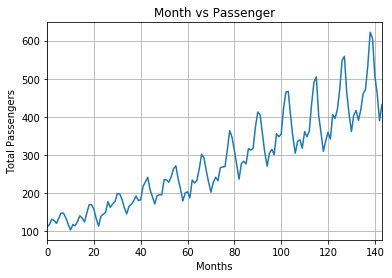

In [10]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

The output shows that over the years the average number of passengers traveling by air increased. The number of passengers traveling within a year fluctuates, which makes sense because during summer or winter vacations, the number of traveling passengers increases compared to the other parts of the year.

## Data Preprocessing

In [23]:
flight_data.columns.dtype

dtype('O')

In [24]:
all_data = flight_data['passengers'].values.astype(float)

The first 132 records will be used to train the model and the last 12 records will be used as a test set.

In [25]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [26]:
print(train_data.shape)
print(test_data.shape)

(132,)
(12,)


Our dataset is not normalized at the moment. The total number of passengers in the initial years is far less compared to the total number of passengers in the later years. It is very important to normalize the data for time series predictions. We will perform min/max scaling on the dataset which normalizes the data within a certain range of minimum and maximum values.

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [28]:
print(train_data_normalized[:5])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]


You can see that the dataset values are now between -1 and 1.

It is important to mention here that data normalization is only applied on the training data and not on the test data. If normalization is applied on the test data, there is a chance that some information will be leaked from training set into the test set.

The next step is to convert our dataset into tensors since PyTorch models are trained using tensors.

In [29]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

Next, we will define a function named create_inout_sequences. The function will accept the raw input data and will return a list of tuples. In each tuple, the first element will contain list of 12 items corresponding to the number of passengers traveling in 12 months, the second tuple element will contain one item i.e. the number of passengers in the 12+1st month.

In [30]:
train_window = 12

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [31]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [32]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]

## Creating LSTM Model

An RNN takes in a number of parameters:

- input_size - the size of the input
- hidden_dim - the number of features in the RNN output and in the hidden state
- n_layers - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
- batch_first - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

LSTM algorithm accepts three inputs: previous hidden state, previous cell state and current input. The hidden_cell variable contains the previous hidden and cell state.

Inside the forward method, the input_seq is passed as a parameter, which is first passed through the lstm layer. The output of the lstm layer is the hidden and cell states at current time step, along with the output. The output from the lstm layer is passed to the linear layer. The predicted number of passengers is stored in the last item of the predictions list, which is returned to the calling function.

In [140]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=16, output_size=1, n_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, n_layers, batch_first=False)

        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        # reset the state of LSTM
        # the state is kept till the end of the sequence
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [141]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [142]:
print(model)

LSTM(
  (lstm): LSTM(1, 16)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)


## Training the Model

In [143]:
epochs = 30

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00110920
epoch:  11 loss: 0.00354349
epoch:  21 loss: 0.00175968
epoch:  29 loss: 0.0001137244


## Making Predictions

In [144]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [145]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [146]:
test_inputs[fut_pred:]

[0.6670703291893005,
 0.6793897151947021,
 0.6272625923156738,
 0.5416034460067749,
 0.6329963803291321,
 0.8425617218017578,
 0.8617932200431824,
 0.6363481283187866,
 0.5661563873291016,
 0.5631925463676453,
 0.667194664478302,
 0.6027524471282959]

In [147]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[483.25849989]
 [486.06116021]
 [474.20223975]
 [454.71478397]
 [475.50667652]
 [523.18279171]
 [527.55795756]
 [476.26919919]
 [460.30057812]
 [459.6263043 ]
 [483.28678617]
 [468.62618172]]


In [148]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


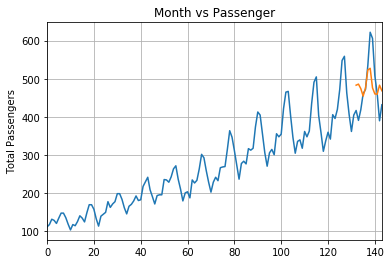

In [149]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

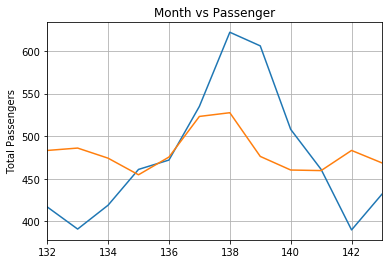

In [150]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()